In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd("~/Thesis/DeepEncoding/Matlab_Models") # requires an absolute path


from keras.models import Sequential, load_model

import tensorflow as tf
from tf_utils import neglogli, poiss_full, get_bps, r2, restore_performance_checkpt, color
from nn_models import gen_fc_model, gen_rnn_model, gen_cnn_model

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX}

/Users/TedMoskovitz/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# model configurations
h_layers_fc = [0,1,2,3]
h_sizes_fc = [1,2,3,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

h_sizes_istac = [1,2,3,4,5]
h_sizes_cbf = [1,2,3,4,5]
h_sizes_rbf = [1,2,3]

hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)}}

nn_models = ['fc', 'rnn', 'cnn']
lnp_models = ['istac', 'cbf', 'rbf']

# 1. Performance

**heatmaps:**

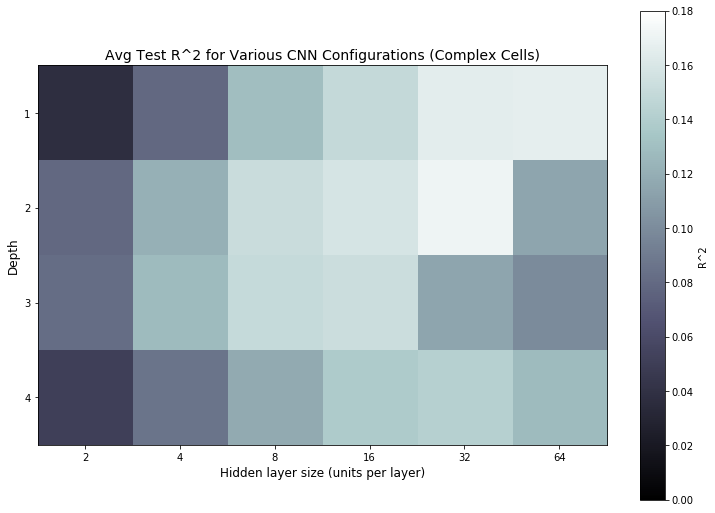

In [3]:
ctype = 'complex'
mtype = 'cnn'
metric = 'r2'

ndepths = hparams[mtype]['ndepths']
nwidths = hparams[mtype]['nwidths']
hidden_sizes = hparams[mtype]['h_sizes']
hidden_layers = hparams[mtype]['h_layers']


lims = {'simple':{'bps':(.35,.75), 'r2':(.12,.26)}, 'complex':{'bps':(0.,.6), 'r2':(0.0,.18)}}
step = {'bps':.05, 'r2':.02}
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype])} # rnn is 3x4 for complex
labels = {'r2':'R^2', 'bps': 'Bits/Spike' }


data = np.genfromtxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', delimiter=',').reshape(shape[mtype])
avg_data = np.mean(data, axis=2)
plt.imshow(avg_data, 'bone', vmin=lims[ctype][metric][0], vmax=lims[ctype][metric][1], interpolation='nearest')
plt.colorbar(orientation="vertical",fraction=0.1,
             ticks=np.arange(lims[ctype][metric][0], lims[ctype][metric][1]+step[metric], step[metric]), label=labels[metric])
plt.xticks(np.arange(nwidths), hidden_sizes)
plt.xlabel('Hidden layer size (units per layer)', fontsize=12)
plt.yticks(np.arange(ndepths), np.asarray(hidden_layers)+1)
plt.ylabel('Depth', fontsize=12)
plt.title('Avg Test %s for Various %s Configurations (%s Cells)' % (labels[metric],mtype.upper(), ctype[0].upper()+ctype[1:]), fontsize=14)
plt.show()

In [4]:
np.where(data==np.max(data))

(array([1]), array([4]), array([3]))

In [10]:
s = V1(ctype, 2)
print s.r2

building data...
fetching repeat data...
done.
0.23088328580896952


**bar charts:**

In [5]:
ctype = 'simple'
metric = 'r2'

rpt_r2s = []
for c in range(cell_nums[ctype]):
    v1 = V1(ctype, c+1, verbose=False)
    rpt_r2s.append(v1.r2)
    

models = ['fc', 'rnn', 'cnn', 'istac', 'cbf', 'rbf']
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype])} 

means = []
stds = []

for mtype in models:
    data = np.genfromtxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', delimiter=',')
    if mtype in nn_models:
        ndepths = hparams[mtype]['ndepths']
        nwidths = hparams[mtype]['nwidths']
        hidden_sizes = hparams[mtype]['h_sizes']
        hidden_layers = hparams[mtype]['h_layers']
        data = data.reshape(shape[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    else:
        data_mean = np.mean(data, axis=0)
        means.append(data_mean[-1])
        data_std = np.std(data, axis=0)
        stds.append(data_std[-1])


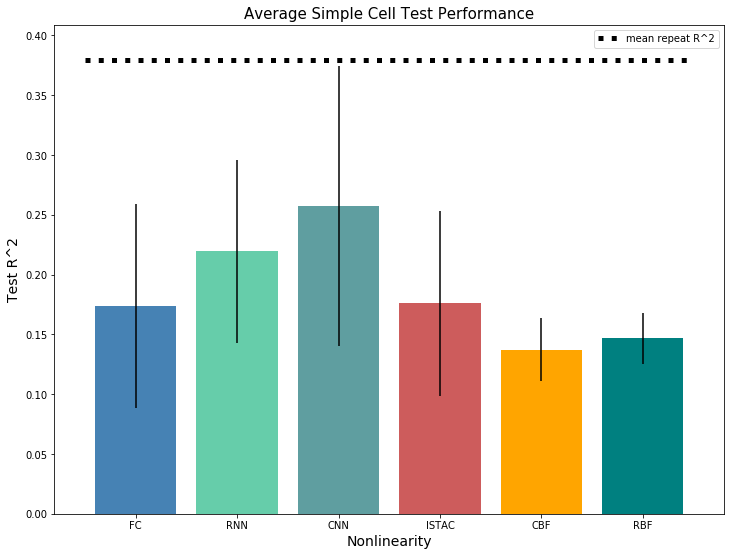

In [6]:
colors = ['steelblue', 'mediumaquamarine', 'cadetblue', 'indianred', 'orange', 'teal']
cs = colors[:len(models)]
tlabels = [m.upper() for m in models]
X = np.linspace(1.,3.,num=len(models))
plt.bar(X, means, width=.32, yerr=stds, tick_label=tlabels, color=cs)
plt.plot([.8, 3.2], [np.mean(rpt_r2s),np.mean(rpt_r2s)], ":", lw=5.,label='mean repeat R^2', color='black')
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=14)
plt.ylabel('Test R^2', fontsize=14)
plt.ylim([0.,np.mean(rpt_r2s)+.03])
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

In [24]:
len(means)

3

# 2. PSTHs

In [7]:
def get_nn_model(celltype, mtype, metric='r2', verbose=True):
    path = 'SavedModels/%s_best_%s_%s.h5' % (celltype, mtype, metric)
    if verbose: print ('loading %s...' % (mtype)); 
    return load_model(path, custom_objects={'poiss_full': poiss_full})

In [20]:
def plot_psth(models, celltype, cell_num, metric='r2', data=None, window=(0,-1)):
    #cell_num = np.where(data==np.max(data))[2][0]+1 if data is not None else 
    v1 = V1(celltype, cell_num, verbose=False)
    plt.imshow(v1.rpt_raster[:,window[0]:window[1]])
    plt.ylabel('Repeat #')
    plt.title('Raster')
    plt.show()
    
    
    plt.plot(v1.psth[window[0]:window[1]], label='Repeat Data', color='black')
    
    
    for m in models:
        flatten = True if m=='fc' else False
        v1 = V1(celltype, cell_num, flatten=flatten, verbose=False)
        if m in nn_models:
            nn = get_nn_model(celltype, m, metric=metric, verbose=False)
            rpt_preds = nn.predict(v1.X_rpt)
        elif m in lnp_models:
            rpt_preds = np.asarray(eng.lnp_predict(celltype, m, v1.rpt_file)) 
        model_psth = v1.convert_psth(rpt_preds)
        plt.plot(model_psth[window[0]:window[1]], label=m.upper())

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Spike Count', fontsize=14)
    plt.legend(fontsize=14)
    plt.title('PSTH for %s Cell' % (celltype[0].upper()+celltype[1:]), fontsize=16)
    plt.show()

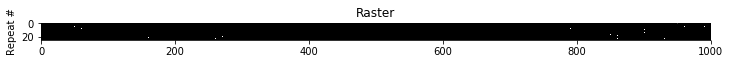

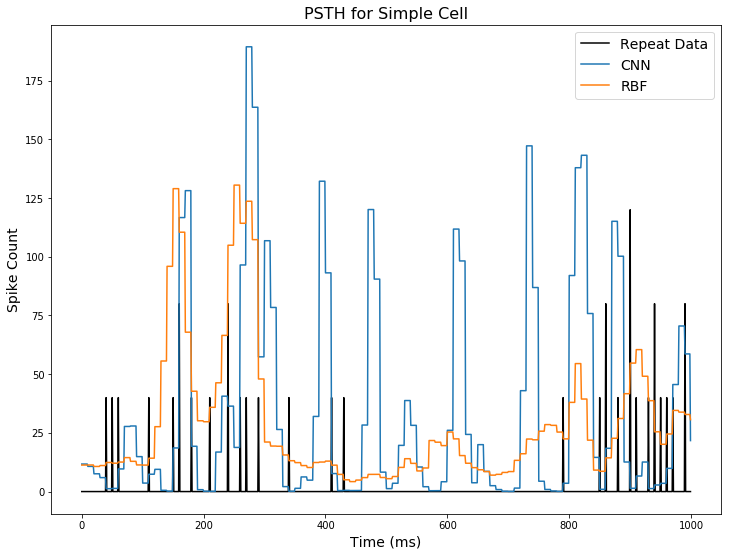

In [21]:
models = ['cnn', 'rbf']
ctype = 'simple'
plot_psth(models, ctype, 1, metric='bps', window=(0,1000))

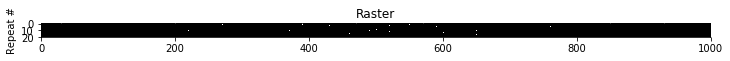

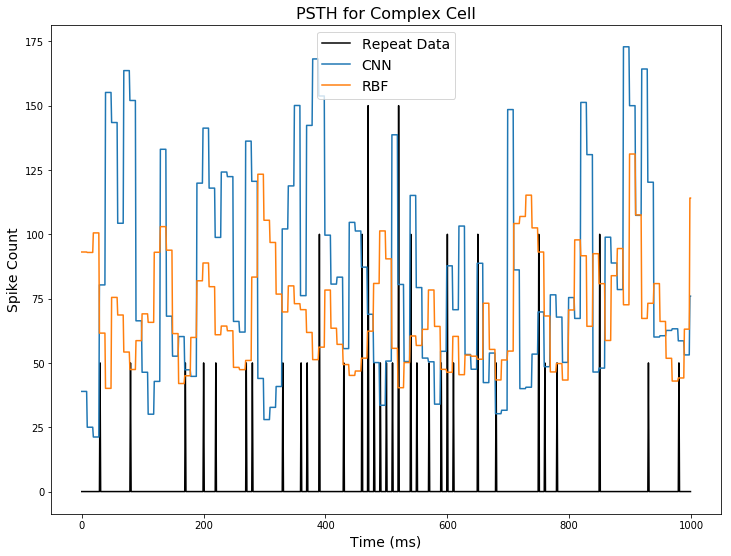

In [26]:
models = ['cnn', 'rbf']
ctype = 'complex'
plot_psth(models, ctype, 3, metric='r2', window=(1000,2000))

# Filters/Weights

In [41]:
def get_nn_wts(model, celltype, metric='r2', verbose=False):
    nn = get_nn_model(celltype, model, metric='r2', verbose=verbose) 
    if verbose: nn.summary(); 
    weights = [l.get_weights() for l in nn.layers]
    return weights

In [42]:
wts = get_nn_wts('cnn', 'simple')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_183 (Conv1D)          (None, 16, 64)            7232      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 4, 64)             0         
__________

In [36]:
len(wts)

15

In [46]:
len(wts[12])

0

In [47]:
wts[0][0].shape

(7, 16, 64)

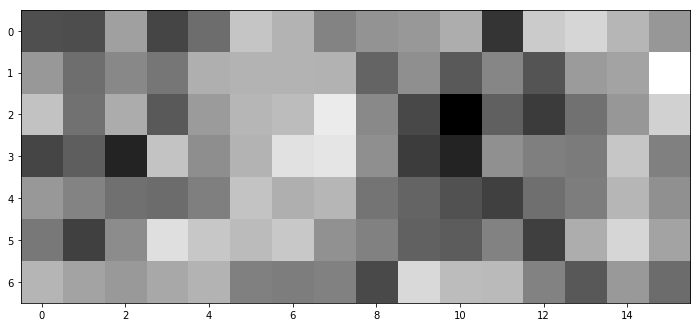

In [50]:
plt.imshow(wts[0][0][:,:,2], interpolation='nearest')
plt.show()